# Scenario 3 Conceptual Model



## 1. Setup the environment

In [26]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Supress depricaiton warmnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# If you want to calculate the harmonic mean in python you need to conda install scipy 
# and uncomment this line
from scipy.stats import hmean

## 2. Create the model object

In [3]:
modelname = "Scenario3_flopy"
exe_path = '/workspaces/modflow/mf2005'
m = flopy.modflow.Modflow(modelname, exe_name = exe_path)

#optional delete old run files
run = 'n'
if run == 'y':
    # file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    file_extensions = ['.dis','.bas','.bcf','.oc','.pcg']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the discretization (DIS package)

For more details on DIS package inputs refer to : https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html 

#### 3.1 Spatial discretization

/opt/conda/envs/hwrs564b/lib/python3.11/site-packages/flopy/mbase.py:623: UserWarning: Unit 11 of package DIS already in use.
  warn(
/opt/conda/envs/hwrs564b/lib/python3.11/site-packages/flopy/mbase.py:632: UserWarning: Two packages of the same type, Replacing existing 'DIS' package.
  warn(


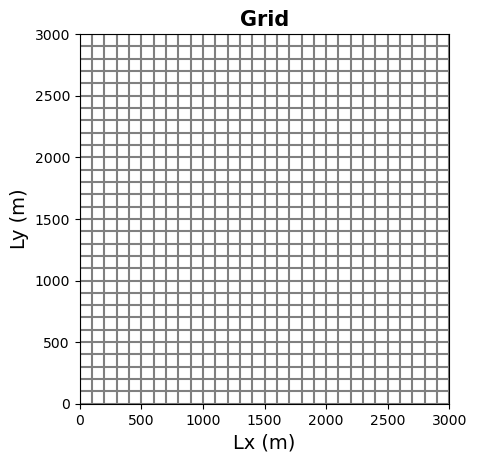

In [4]:
nrow = 30 #number of rows
ncol = 30 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x direction 
dy= 100 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 500.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

top = ztop
botm = zbot   # single layer bottom

dis = flopy.modflow.ModflowDis(
    m,
    nlay=nlay, nrow=nrow, ncol=ncol,
    delr=dx, delc=dy,
    top=top, botm=botm,
    steady=True
)


# Temporal discretization
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type


#Create DIS object
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


#Plot the gird
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

# Image of conceptual model

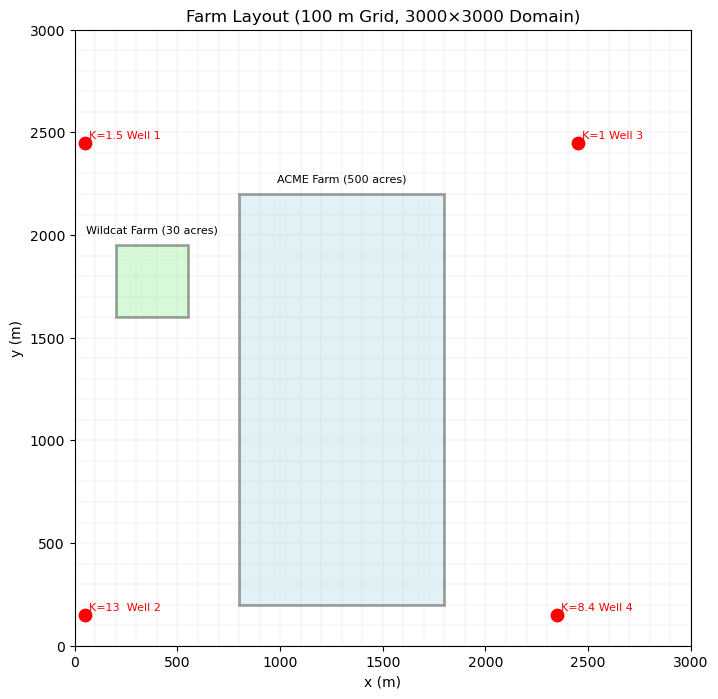

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Fixed domain size ---
Lx = 3000
Ly = 3000
grid_spacing = 100
padding = 200

fig, ax = plt.subplots(figsize=(8, 8))

# --- Draw grid (once) ---
for x in np.arange(0, Lx + grid_spacing, grid_spacing):
    ax.axvline(x, color="gray", linewidth=0.2, alpha=0.4)
for y in np.arange(0, Ly + grid_spacing, grid_spacing):
    ax.axhline(y, color="gray", linewidth=0.2, alpha=0.4)

# --- Farm sizes / positions ---
wildcat_x, wildcat_y = padding, 1600
wildcat_w, wildcat_h = 350, 350

acme_x, acme_y = 800, padding
acme_w, acme_h = 1000, 2000

# --- Draw farms (ONE time each: shaded + border) ---
wildcat = plt.Rectangle(
    (wildcat_x, wildcat_y), wildcat_w, wildcat_h,
    facecolor="lightgreen", alpha=0.35,
    edgecolor="black", linewidth=2, zorder=3
)
ax.add_patch(wildcat)
ax.text(wildcat_x + wildcat_w/2, wildcat_y + wildcat_h + 60,
        "Wildcat Farm (30 acres)", ha="center", fontsize=8, zorder=4)

acme = plt.Rectangle(
    (acme_x, acme_y), acme_w, acme_h,
    facecolor="lightblue", alpha=0.35,
    edgecolor="black", linewidth=2, zorder=3
)
ax.add_patch(acme)
ax.text(acme_x + acme_w/2, acme_y + acme_h + 60,
        "ACME Farm (500 acres)", ha="center", fontsize=8, zorder=4)

# --- Well / point locations from row/col (bottom-left origin) ---
# If these are wells or K control points, this is the same plotting logic.
# (row, col, label)
points_rc = [
    (1,  0,  "K=13  Well 2"),
    (24, 0,  "K=1.5 Well 1"),
    (1,  23, "K=8.4 Well 4"),
    (24, 24, "K=1 Well 3")
]

x_pts = []
y_pts = []
labels = []

for r, c, label in points_rc:
    x = (c + 0.5) * dx
    y = (r + 0.5) * dy   # bottom-left origin
    x_pts.append(x)
    y_pts.append(y)
    labels.append(label)

ax.scatter(x_pts, y_pts, color="red", s=80, zorder=5)

for x, y, lab in zip(x_pts, y_pts, labels):
    ax.text(x + dx*0.2, y + dy*0.2, lab,
            color="red",
            fontsize=8,
            zorder=6)


# --- Formatting ---
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("Farm Layout (100 m Grid, 3000×3000 Domain)")
ax.set_aspect("equal")

plt.show()


## 4. Setup constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbas.html

#### 4.1 Define cell activity: IBOUND 

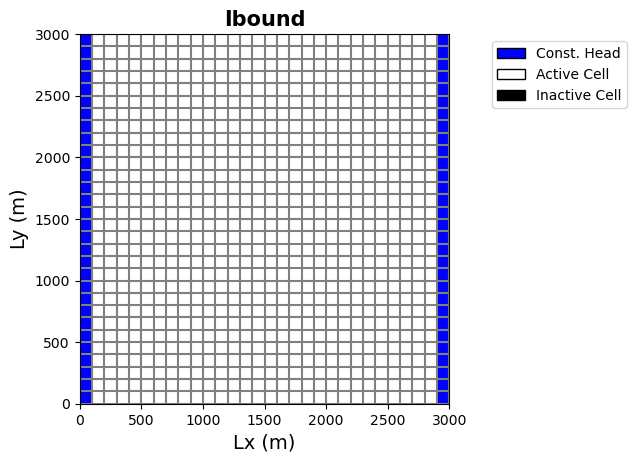

In [6]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

#print("ibound values: \n", ibound)

#Defining start heads
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = 595    #replace first (left) col with desired head value
H_init[:, :, -1] = 550   #replace first (left) col with desired head value

#print("starting head values: \n", H_init)

# Create BAS object
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#plot the grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

## 5. Setup Layer Properties  (LPF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html

#### 5.1 Set layer properties

In [7]:
# Set layer properties
K_horiz = 1.    #horizontal hydraulic conductivity 
K_vert = 1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 0       #0=confined, >0 = unconfined

#Set cell properties and show K in top layer
K_vals = np.zeros((nlay,nrow,ncol))
K_vals[:,:,:] = 1        
K_vals

array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.

## 5b. Create K Field

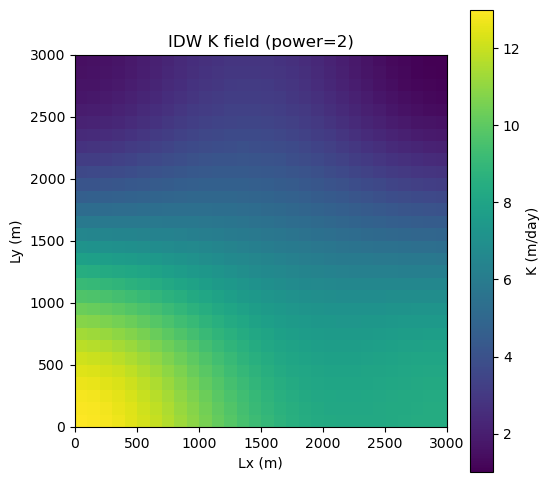

In [8]:

# --- K corner values (your inclusions) ---
K_tl = 1.5   # top-left
K_tr = 1.0   # top-right
K_bl = 13.0  # bottom-left
K_br = 8.4   # bottom-right

# --- Domain size in meters (match your axes in the figure) ---
Lx = 3000.0
Ly = 3000.0

# --- Build x,y coordinates for cell centers ---
dx = Lx / ncol
dy = Ly / nrow

x = (np.arange(ncol) + 0.5) * dx
y = (np.arange(nrow) + 0.5) * dy
X, Y = np.meshgrid(x, y)  # shape (nrow, ncol)

# --- Control points: (x, y, K) at the four corners ---
pts = np.array([
    [0.0,   Ly,   K_tl],   # top-left
    [Lx,    Ly,   K_tr],   # top-right
    [0.0,   0.0,  K_bl],   # bottom-left
    [Lx,    0.0,  K_br],   # bottom-right
], dtype=float)

power = 2  # IDW power

# --- IDW interpolation ---
K2D_num = np.zeros_like(X, dtype=float)
K2D_den = np.zeros_like(X, dtype=float)

eps = 1e-12  # avoid divide-by-zero

for (px, py, pk) in pts:
    d = np.sqrt((X - px)**2 + (Y - py)**2)
    w = 1.0 / np.maximum(d, eps)**power
    K2D_num += w * pk
    K2D_den += w

K2D = K2D_num / K2D_den  # final interpolated K field (nrow, ncol)

# --- Put into 3D K array ---
K_vals = np.zeros((nlay, nrow, ncol), dtype=float)
K_vals[:, :, :] = K2D


fig = plt.figure(figsize=(6,6))
im = plt.imshow(
    K_vals[0, :, :],
    origin="lower",          # (0,0) at bottom-left
    extent=[0, Lx, 0, Ly],   # axis labels in meters
    interpolation="none"
)
plt.colorbar(im, label="K (m/day)")
plt.xlabel("Lx (m)")
plt.ylabel("Ly (m)")
plt.title(f"IDW K field (power={power})")

plt.show()


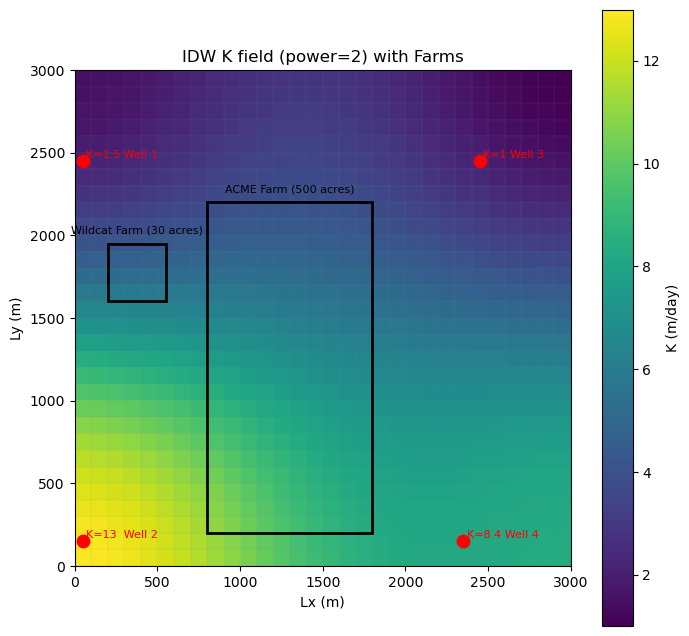

In [9]:

# --- Fixed domain ---
Lx = 3000
Ly = 3000
grid_spacing = 100
padding = 200

# --- Farm sizes / positions ---
wildcat_width = 350
wildcat_height = 350
acme_width = 1000
acme_height = 2000

wildcat_x = padding
wildcat_y = 1600

acme_x = 800
acme_y = padding


fig, ax = plt.subplots(figsize=(8, 8))


im = ax.imshow(
    K_vals[0, :, :],
    origin="lower",
    extent=[0, Lx, 0, Ly],
    interpolation="none"
)

cbar = fig.colorbar(im, ax=ax, label="K (m/day)")

# --- Draw grid on top ---
for x in np.arange(0, Lx + grid_spacing, grid_spacing):
    ax.axvline(x, color='gray', linewidth=0.2, alpha=0.4, zorder=2)

for y in np.arange(0, Ly + grid_spacing, grid_spacing):
    ax.axhline(y, color='gray', linewidth=0.2, alpha=0.4, zorder=2)

# --- Draw farms on top ---
wildcat = plt.Rectangle(
    (wildcat_x, wildcat_y),
    wildcat_width,
    wildcat_height,
    fill=False,
    edgecolor='black',
    linewidth=2,
    zorder=3
)
ax.add_patch(wildcat)

ax.text(
    wildcat_x + wildcat_width/2,
    wildcat_y + wildcat_height + 60,
    "Wildcat Farm (30 acres)",
    ha='center',
    fontsize=8,
    color="black",
    zorder=4
)

acme = plt.Rectangle(
    (acme_x, acme_y),
    acme_width,
    acme_height,
    fill=False,
    edgecolor='black',
    linewidth=2,
    zorder=3
)
ax.add_patch(acme)

ax.text(
    acme_x + acme_width/2,
    acme_y + acme_height + 60,
    "ACME Farm (500 acres)",
    ha='center',
    fontsize=8,
    color="black",
    zorder=4
)

points_rc = [
    (1,  0,  "K=13  Well 2"),
    (24, 0,  "K=1.5 Well 1"),
    (1,  23, "K=8.4 Well 4"),
    (24, 24, "K=1 Well 3")
]

x_pts = []
y_pts = []
labels = []

for r, c, label in points_rc:
    x = (c + 0.5) * dx
    y = (r + 0.5) * dy   # bottom-left origin
    x_pts.append(x)
    y_pts.append(y)
    labels.append(label)

ax.scatter(x_pts, y_pts, color="red", s=80, zorder=5)

for x, y, lab in zip(x_pts, y_pts, labels):
    ax.text(x + dx*0.2, y + dy*0.2, lab,
            color="red",
            fontsize=8,
            zorder=6)



ax.set_xlabel("Lx (m)")
ax.set_ylabel("Ly (m)")
ax.set_title(f"IDW K field (power={power}) with Farms")
ax.set_aspect("equal")

plt.show()




#### 5b.2 Make BCF object

In [10]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[0,:,:], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None) 


## 6. Setup outputs by stress period (OC Package)
For more details on OC Package: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfoc.html

#### 6.1 Setup outputs

In [11]:
#create oc stress period data. 
#(0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", spd)

#Make OC object
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)



oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


## 7. Set the numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

#### 7.1 Make the PCG object

In [12]:
pcg = flopy.modflow.ModflowPcg(model=m)

## 8. Add wells for the constant flux boundary (WEL Package)
For more details on the WEL package see: https://flopy.readthedocs.io/en/3.3.4/source/flopy.modflow.mfwel.html

#### 8.1 Setup the well parameters (use this to set a defined flux boundary)

{0: [[0, 17, 3, -346], [0, 3, 9, -5230], [0, 21, 17, -5230]]}


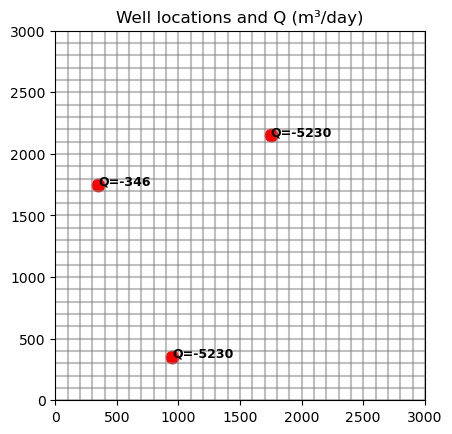

In [13]:
Qw_in = -346                   # Volumetric flux from the well in units of L3/T 
QACME1_in = -5230
QACME2_in = -5230
#fluxesA = [0,7.029,7.0145,QACME1_in],[0,17.087,7.01451,QACME2_in]

sp_fluxes = {0: [[0,17,3,Qw_in],[0,3,9,QACME1_in],[0,21,17,QACME2_in]]}              #create a dictionary with entries for each stress period

print(sp_fluxes)

modelmap = flopy.plot.PlotMapView(model=m, layer=0)
modelmap.plot_grid(alpha=0.5)

for (lay, r, c, q) in sp_fluxes[0]:
    x = (c + 0.5) * dx
    y = (r + 0.5) * dy   # <-- fixed orientation
    plt.scatter(x, y, s=80, color="red")
    plt.text(x, y, f"Q={q}", fontsize=9, fontweight='bold')

plt.title("Well locations and Q (m³/day)")
plt.show()


#### 8.2 Make the WEL object

In [14]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=sp_fluxes)  #create object for WEL package

## 9. Add recharge (RCH Package)

For more details on the recharge package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfrch.html

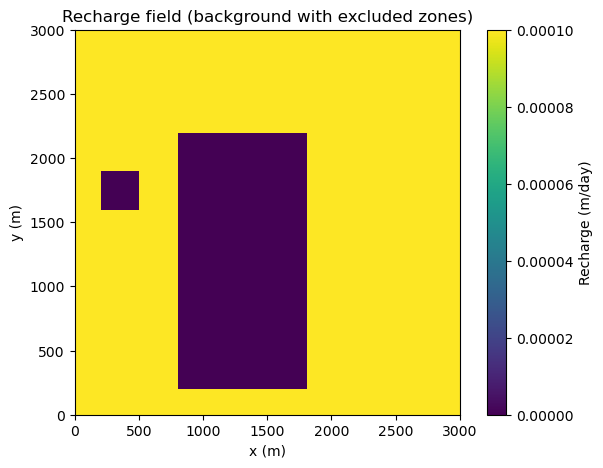

In [15]:
rch_bg = 1e-4   # m/day

rech_zone = np.ones((nrow, ncol), dtype=float) * rch_bg

x_centers = (np.arange(ncol) + 0.5) * dx
y_centers = (np.arange(nrow) + 0.5) * dy
Xc, Yc = np.meshgrid(x_centers, y_centers)

# NO-recharge masks (purple)
# mask1 = (Yc < 500)   # bottom band should be excluded

mask2 = (            # acme farm (large rectangle)
    (Xc > 800) & (Xc < 1800) &
    (Yc > 200) & (Yc < 2200)
)

mask3 = (            # wildcat farm (small rectangle, top-left-ish)
    (Xc > 200) & (Xc < 550) &
    (Yc > 1600) & (Yc < 1950)
)

no_rch = mask2 | mask3
rech_zone[no_rch] = 0.0

Lx = ncol * dx
Ly = nrow * dy

plt.figure(figsize=(7,5))
plt.imshow(rech_zone, origin="lower", extent=[0, Lx, 0, Ly])
plt.colorbar(label="Recharge (m/day)")
plt.title("Recharge field (background with excluded zones)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()




rch = flopy.modflow.ModflowRch(
    m,
    nrchop=1,
    rech=rech_zone,
    ipakcb=53
)




## 9. Write inputs and run the model 

#### 9.1 Write Inputs

In [16]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### 9.2 Run the model

In [17]:
success, mfoutput = m.run_model(pause=False, report=True, silent=False)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Scenario3_flopy.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/12  3:33:17

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/12  3:33:17
 Elapsed run time:  0.012 Seconds

  Normal termination of simulation


## 10. Plot the results  

#### 10.1 Read in the model outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile

##### Read the heads 

In [18]:
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

#print('timesteps:', times)         
#print('final head:', 'dimensions', np.shape(head), '\n', head)    
#print('initial head:', 'dimensions', np.shape(H_init), '\n', H_init)
#print('well fluxes:', 'dimensions', np.shape(fluxes), '\n', fluxes)

##### Write Heads as csv

In [19]:
with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
    writer = csv.writer(csvfile, delimiter=',')        
    for i in range(len(head[0,:,0])):                    #writes each row
        writer.writerow(head[0,i,:])


##### Read the Water Balance and use it to find distribution of fluxes along boundary

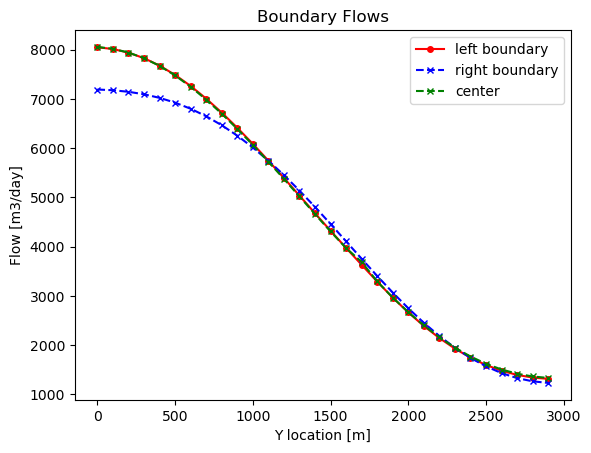

(30, 30)
7941.854
7942.896
[7940.8315 7941.854  7942.896  7944.6626 7948.983  7959.4053 7980.6885
 8007.824  7947.5586 7163.295  7103.1255 7123.965  7137.176  7139.1294
 7134.971  7128.496  7121.883  7116.291  7113.164  7111.931  7112.6255
 7115.061  7118.904  7123.725  7129.043  7134.362  7139.2026 7143.1284
 7145.76      0.    ]


In [20]:
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells     
         #string options are in the list file under output control (make sure to include spaces!)

flux_vals=np.squeeze(frf)
leftflux = flux_vals[:,0]
rightflux = flux_vals[:,-2]
#centerflux = flux_vals[:,12]
centerflux = flux_vals[:,2]


bdryflux_fig = plt.figure() 
x=np.arange(0,ncol*dx,dx) 
plt.plot(x,leftflux,marker='o', color='red', markersize=4, linestyle='-',label="left boundary")
plt.plot(x,rightflux,marker='x', color='blue', markersize=4, linestyle='--',label="right boundary")
plt.plot(x,centerflux,marker='x', color='green', markersize=4, linestyle='--',label="center")
plt.xlabel('Y location [m]')
plt.ylabel('Flow [m3/day]')
plt.title("Boundary Flows")
plt.legend()
plt.show()

print(flux_vals.shape)
print(flux_vals[2,1])
print(flux_vals[2,2])
print(flux_vals[2,:])



### Calculate the total flux

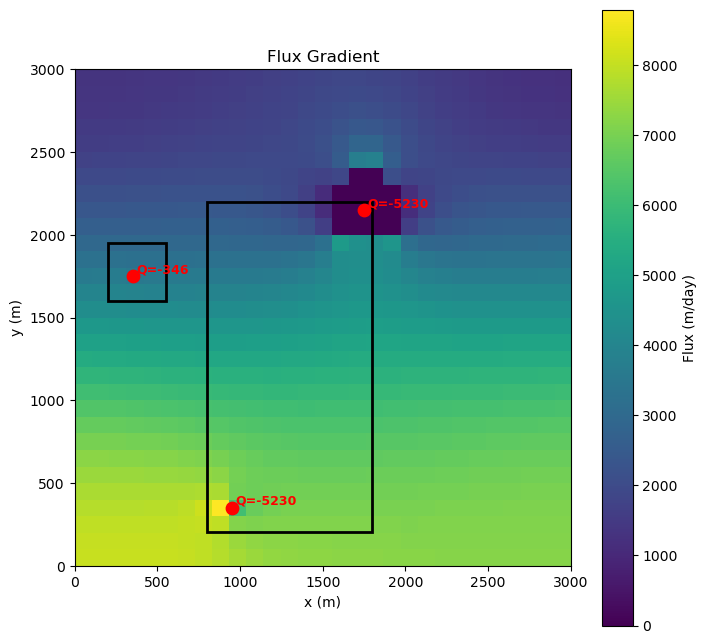

In [21]:
plt.figure(figsize=(8, 8))


plt.imshow(
    flux_vals[:, :-1],
    origin='lower',
    extent=[0, Lx, 0, Ly],   # important for correct scaling
    cmap='viridis'
)

plt.colorbar(label="Flux (m/day)")

padding = 200



# Wildcat Farm
plt.gca().add_patch(plt.Rectangle(
    (wildcat_x, wildcat_y),
    wildcat_w,
    wildcat_h,
    fill=False,            
    edgecolor='black',
    linewidth=2,
    zorder=3
))

# ACME Farm
plt.gca().add_patch(plt.Rectangle(
    (acme_x, acme_y),
    acme_w,
    acme_h,
    fill=False,             
    edgecolor='black',
    linewidth=2,
    zorder=3
))



for (lay, r, c, q) in sp_fluxes[0]:
    x = (c + 0.5) * dx
    y = (r + 0.5) * dy
    plt.scatter(x, y, s=80, color="red", zorder=5)
    plt.text(x + dx*0.2, y + dy*0.2,
             f"Q={q}",
             fontsize=9,
             fontweight='bold',
             color="red",
             zorder=6)

plt.title("Flux Gradient")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.gca().set_aspect('equal')

plt.show()


In [22]:
#Calculate the total flux across the model
flux_tot  = np.sum(flux_vals[:, 0]) #total flux through one column of the model [m3/day]

# Calculate the equivalent K (q=k*A* dh/dl)
area = nrow *dy * (ztop-zbot)
dh_dl= (np.mean((H_init[0,:,0]-H_init[0,:,-1])))/Lx
#dh_dl = 10/2500
k_eff = flux_tot/area/dh_dl

# Calculate the arithmetic mean K
k_arr = np.mean(K_vals)

# Calcualte the harmonic mean K
k_harm = hmean(K_vals.flatten()) 

print("LowK", np.min(np.array([K_tl,K_tr,K_bl,K_br])), "ArrMean", np.round(k_arr,2), "Hmean", np.round(k_harm,2), "Keff", np.round(k_eff,2), "Q", np.round(flux_tot,2) )


LowK 1.0 ArrMean 5.98 Hmean 4.29 Keff 6.11 Q 137544.4


#### 10.2 Evaluate the head gradients

Head Gradient 0.015 m/m


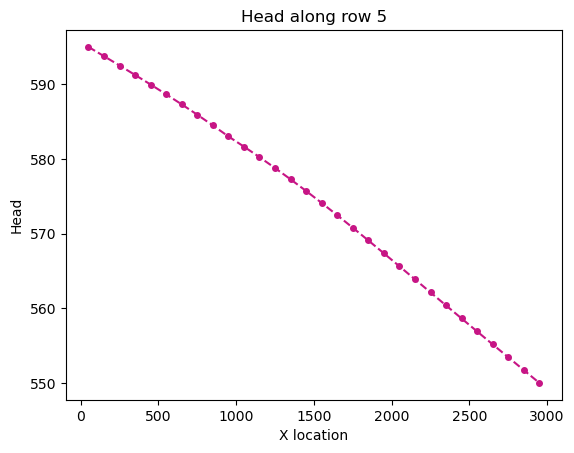

In [23]:
head_fig = plt.figure() 
#x=np.arange(100,2600,100) 
x=np.arange(dx/2,Lx,dx)
y=head[0,4,:]
plt.plot(x,y,marker='o', color='mediumvioletred', markersize=4, linestyle='--')
plt.xlabel('X location')
plt.ylabel('Head')
plt.title("Head along row 5")
#plt.axvline(x=1200)

#Save figure
# plt.savefig('Head_Transect.png') #save figure as a png

hgrad=(head[0,4,0]-head[0,4,-1])/Lx
print("Head Gradient", hgrad, "m/m") 

#### 10.3 3D plot of heads

Text(0.5, 0.92, 'Steady-State Model Head Profile')

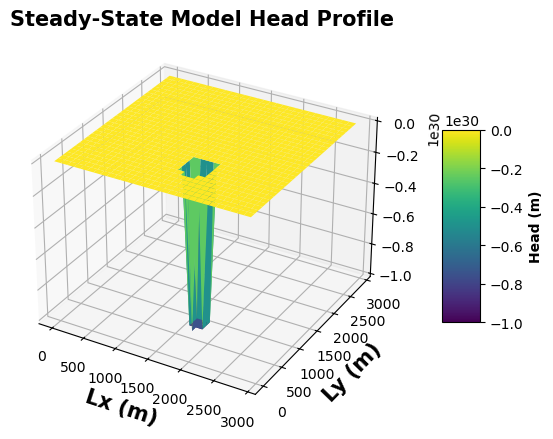

In [24]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
#ax = fig_3d.gca(projection='3d')
ax = fig_3d.add_subplot(111,projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

### 10.4 Contour Head plot

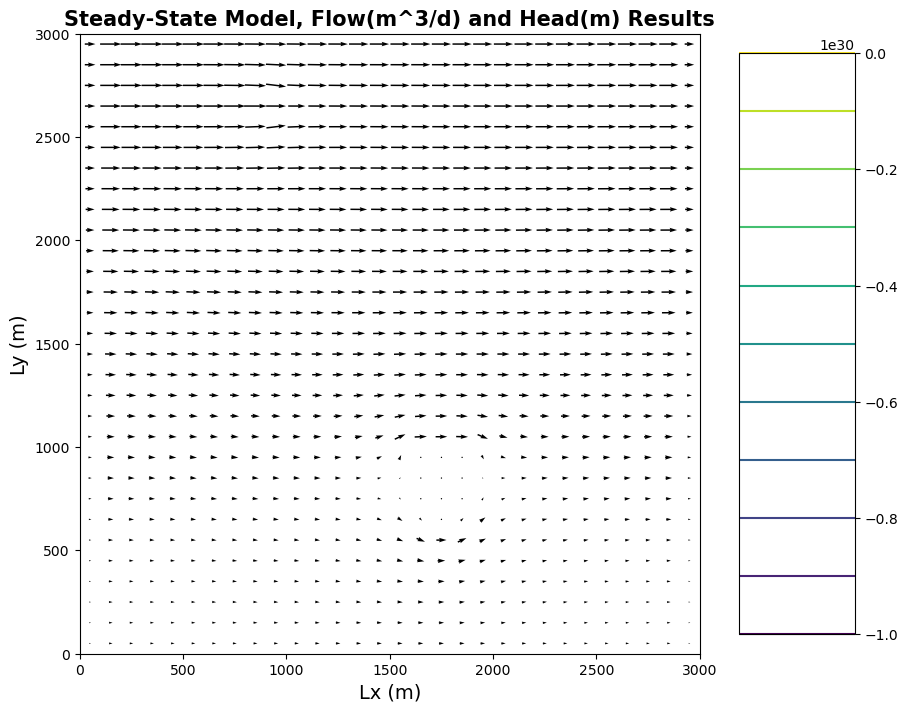

In [25]:
#Calculate the volumetric dischard (m3/day)
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    (frf[0], fff[0], None), m) 

#plot first contour plot
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
quiver = modelmap.plot_vector(qx, qy)
#flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
# plt.savefig('BoxModel_vectors.png')   
#plt.show(modelmap)